In [57]:
import os
import pickle
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

### Clean text data to prepare for TFIDF vecotrization

In [58]:
def get_new_bedroom(fea):
    """If no bedroom, insert bedroom as 0."""
    return [fea[0], "0 hab.", fea[1], fea[-1]]

def get_new_bathroom(fea):
    """If no bathroom, insert bedroom as 0."""
    return [fea[0], fea[1], "0 baño", fea[-1]]

def clean_features(data):
    """Make sure all features are consistent with the format
    [m2, bedroom, bathroom, price/m2]"""
    cleaned_data = []
    for i, d in enumerate(data):
        features = d["features"]
        # If no bedroom, insert bedroom as 0
        if not bool(re.match("\d hab", features[1])):
            if len(features) < 4:
                features = get_new_bedroom(features)
                d["features"] = features
        features = d["features"]
        # If no bathroom, insert bedroom as 0
        if not bool(re.match("\d baño", features[2])):
            features = get_new_bathroom(features)
            d["features"] = features
        cleaned_data.append(d)
    return cleaned_data

def clean_data(data, train=False):
    """Clean data to prepare for modeling
    
    Args: 
    - data: original data from pickle file
    - train (bool): indicator of training/test set
    
    Returns:
    - df: cleaned df ready for model
    """
    # Clean feature column
    clean_data = clean_features(data)

    # Convert to df
    df = pd.DataFrame(clean_data)

    # Create columns m^2, bedrooms, bathrooms from features
    df['m2'] = df['features'].apply(lambda x: float(x[0].split()[0]))
    df['bedrooms'] = df['features'].apply(lambda x: float(x[1].split()[0]))
    df['bathrooms'] = df['features'].apply(lambda x: float(x[2].split()[0]))

    # Drop columns with repetitive data or no variation
    df = df.drop(['subtype', 'selltype', 'features'], axis=1)

    # Turn price into integer column -> only needed for training set
    if train is True:
        df['price'] = df['price'].apply(lambda x: int(x.replace(".", "").split()[0]))
    
    return df

In [122]:
import spacy 
nlp = spacy.load("es_core_news_sm")

In [123]:
# Get Spanish stopwords
nltk.download('stopwords')
stopword_es = nltk.corpus.stopwords.words('spanish')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/swaterman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Prepare Data

In [124]:
train_file_path = os.path.expanduser('~/data/train.pickle')
with open(train_file_path, 'rb') as file:
    train_data = pickle.load(file)

test_file_path = os.path.expanduser('~/data/test_kaggle.pickle')
with open(test_file_path, 'rb') as file:
    test_data = pickle.load(file)

In [125]:
# Clean data
df_train = clean_data(train_data, train=True)
X_test = clean_data(test_data, train=False)

In [126]:
features = [col for col in df_train.columns if col != 'price']
X = df_train[features]
y = df_train['price']

# Split into 80% training and 20% validation.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=0)

# Reset and drop index
X_train.reset_index(inplace=True)
X_train.drop('index', axis=1, inplace=True)
X_val.reset_index(inplace=True)
X_val.drop('index', axis=1, inplace=True)

#### Explore descriptions

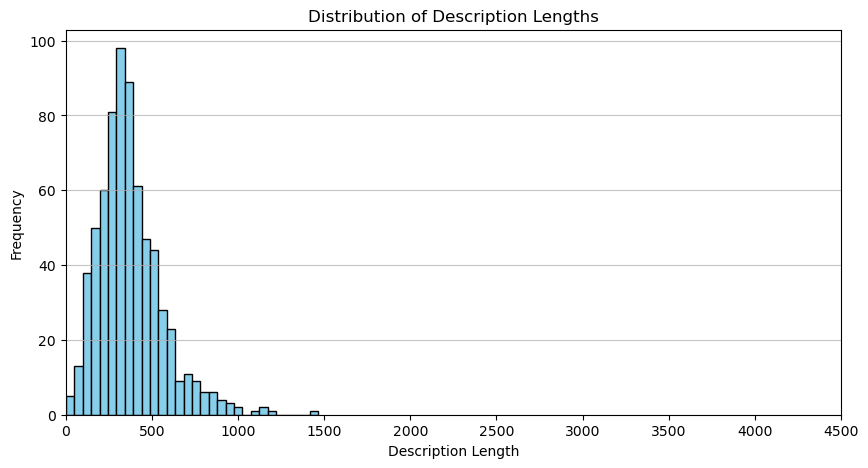

In [66]:
X_train['desc_length'] = X_train['desc'].apply(len)

# Plot description length distribution
plt.figure(figsize=(10, 5))
plt.hist(X_train['desc_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Description Lengths')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0, 4500)
plt.show()

In [67]:
# Function to lemmatize Spanish sentence
def lemmatize_sentence_spacy_es(sentence):
    # Process the sentence
    doc = nlp(sentence)
    # Extract the lemma for each token and join back into a string
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

In [68]:
X_train['lemmatized_desc_length'] = X_train['desc'].apply(lambda x: lemmatize_sentence_spacy_es(x)).apply(len)

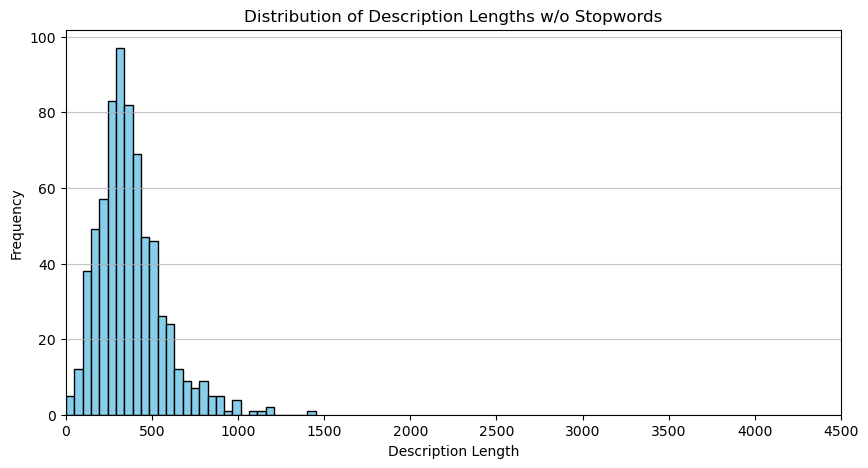

In [69]:
# Plot description lematized/tokenized length distribution no stopwords
plt.figure(figsize=(10, 5))
plt.hist(X_train['lemmatized_desc_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Description Lengths w/o Stopwords')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0, 4500)
plt.show()

In [70]:
# Function to lemmatize Spanish sentence and keep only nouns and verbs
def lemmatize_sentence_spacy_es_nouns_verbs(sentence):
    # Process the sentence
    doc = nlp(sentence)
    # Extract the lemma for each token and join back into a string - do not include adjectives
    return " ".join([token.lemma_ for token in doc if token.pos_ == "NOUN" or token.pos_ == "VERB"])

X_train['lemmatized_desc_length_nouns_verbs'] = X_train['desc'].apply(lambda x: lemmatize_sentence_spacy_es_nouns_verbs(x)).apply(len)

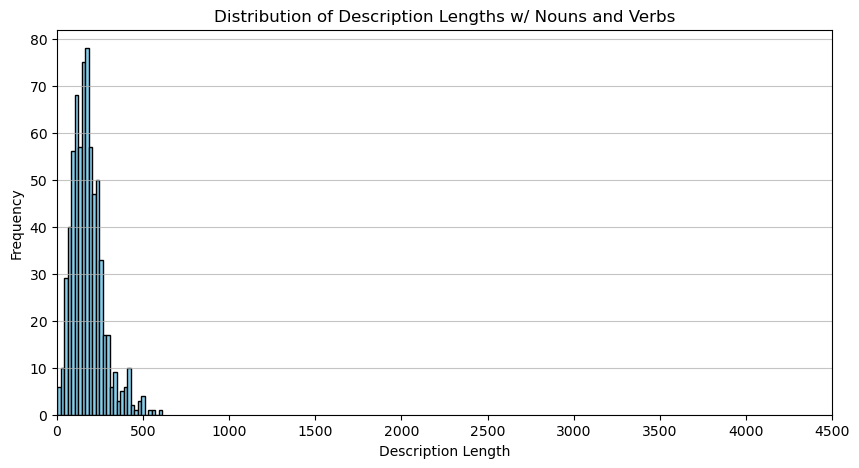

In [71]:
# Plot description lematized/tokenized length distribution NOUNs and VERBS only
plt.figure(figsize=(10, 5))
plt.hist(X_train['lemmatized_desc_length_nouns_verbs'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Description Lengths w/ Nouns and Verbs')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0, 4500)
plt.show()

In [72]:
# Function to lemmatize Spanish sentence and keep only nouns
def lemmatize_sentence_spacy_es_nouns(sentence):
    # Process the sentence
    doc = nlp(sentence)
    # Extract the lemma for each token and join back into a string
    return " ".join([token.lemma_ for token in doc if token.pos_ == "NOUN"])

X_train['lemmatized_desc_length_nouns_only'] = X_train['desc'].apply(lambda x: lemmatize_sentence_spacy_es_nouns(x)).apply(len)

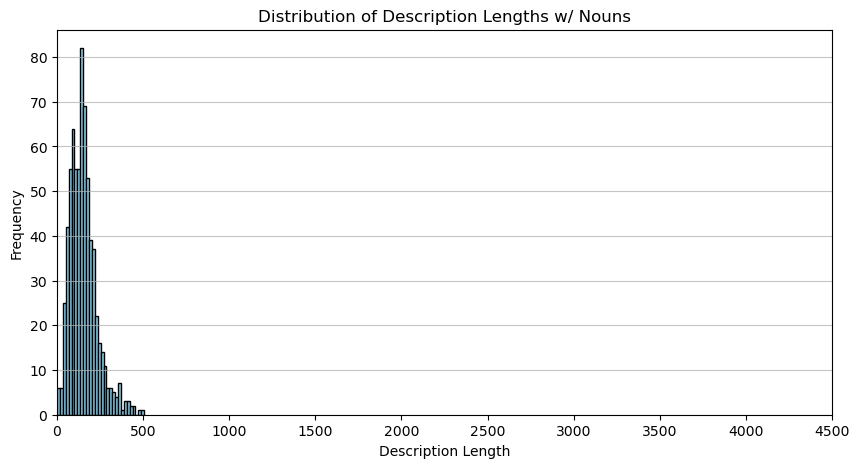

In [73]:
# Plot description lematized/tokenized length distribution NOUNs only
plt.figure(figsize=(10, 5))
plt.hist(X_train['lemmatized_desc_length_nouns_only'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Description Lengths w/ Nouns')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0, 4500)
plt.show()

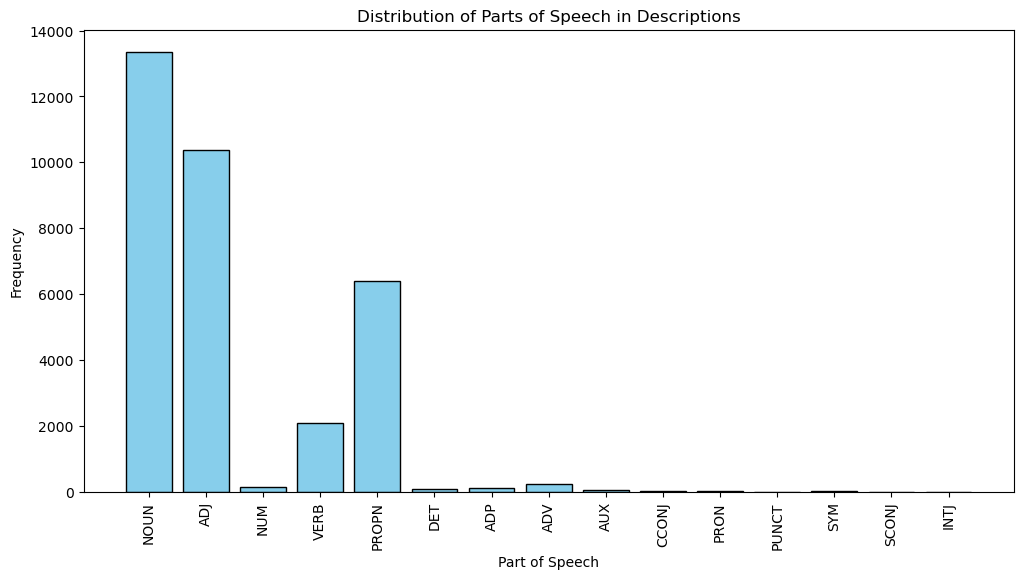

In [74]:
# Parts of Speech Distribution
def pos_distribution(descriptions):
    pos_counts = Counter()
    for desc in descriptions:
        doc = nlp(desc)
        # Increment POS counts
        pos_counts.update([token.pos_ for token in doc if not token.is_punct and not token.is_stop])

    pos, frequency = zip(*pos_counts.items())
    
    # Plot the POS distribution
    plt.figure(figsize=(12, 6))
    plt.bar(pos, frequency, color='skyblue', edgecolor='black')
    plt.title('Distribution of Parts of Speech in Descriptions')
    plt.xlabel('Part of Speech')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()
    
descriptions = X_train['desc'].tolist()  
pos_distribution(descriptions)


### TFIDF embeddings

In [127]:
def clean_text(text):
    """Clean text to prepare for word_embeddings. 
    
    Args:
    - text (str): raw text
    
    Returns: 
    - text (str): cleaned text with stopwords removed
    """
    # Remove newline characters
    text = re.sub(r'\n', ' ', text)
    # Remove backslash and following character
    text = re.sub(r'\\.', '', text)
    # Remove other special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Make text lower case
    text = text.lower()
    # Make sure m^2 and euros is same 
    text = re.sub(r'(m2)|(m²)', ' m²', text)
    text = re.sub(r'(euro[^s])|(euros)|(€)', ' euros', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Process the text using SpaCy
    doc = nlp(text)

    # Filter nouns and adjectives, ignoring stopwords, lemmatize words
    filtered_tokens = [token.lemma_ for token in doc if token.pos_ in ['NOUN'] and not token.is_stop]

    # Join words back to string
    cleaned_text = ' '.join(filtered_tokens)

    return cleaned_text

In [128]:
def check_word_in_text(text, word):
    # Check if the word is in the text
    return 1 if word.lower() in text.lower() else 0

In [129]:
def top_k_tfidf_words(df, col='desc', max_features=100, k=50):
    # Compile all text from all houses
    total_text = df[col].values

    # Initialize TF-IDF Vectorizer, excluding Spanish stopwords
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)

    # Fit and transform the descriptions to a TF-IDF matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform(total_text)

    # Sum the TF-IDF scores for each word across all documents
    tfidf_sum = np.sum(tfidf_matrix, axis=0)
    tfidf_scores = [(word, tfidf_sum[0, idx]) for word, idx in tfidf_vectorizer.vocabulary_.items()]

    # Sort words by their score to find the most important ones
    sorted_tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)

    top_words = [w[0] for w in sorted_tfidf_scores[:k]]

    return top_words, sorted_tfidf_scores

In [130]:
# Clean description text 
df_train['desc'] = df_train['desc'].apply(lambda x: clean_text(x))
X_test['desc'] = X_test['desc'].apply(lambda x: clean_text(x))

features = [col for col in df_train.columns if col != 'price']
X = df_train[features]
y = df_train['price']

# Split into 80% training and 20% validation.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=0)

# Reset and drop index
X_train.reset_index(inplace=True)
X_train.drop('index', axis=1, inplace=True)
X_val.reset_index(inplace=True)
X_val.drop('index', axis=1, inplace=True)

In [131]:
top_words, top_words_tuples = top_k_tfidf_words(df_train, col='desc', max_features=100, k=50)

In [132]:
# Apply the function to each row in the DataFrame
def create_features_for_top_words(df, col='desc', top_words=top_words):
    for word in top_words:
        df[word] = df[col].apply(lambda x: check_word_in_text(x, word))
    # Drop column
    df.drop(col, axis=1, inplace=True)
    return df

X_train = create_features_for_top_words(X_train, col='desc', top_words=top_words)
X_val = create_features_for_top_words(X_val, col='desc', top_words=top_words)
X_test = create_features_for_top_words(X_test, col='desc', top_words=top_words)

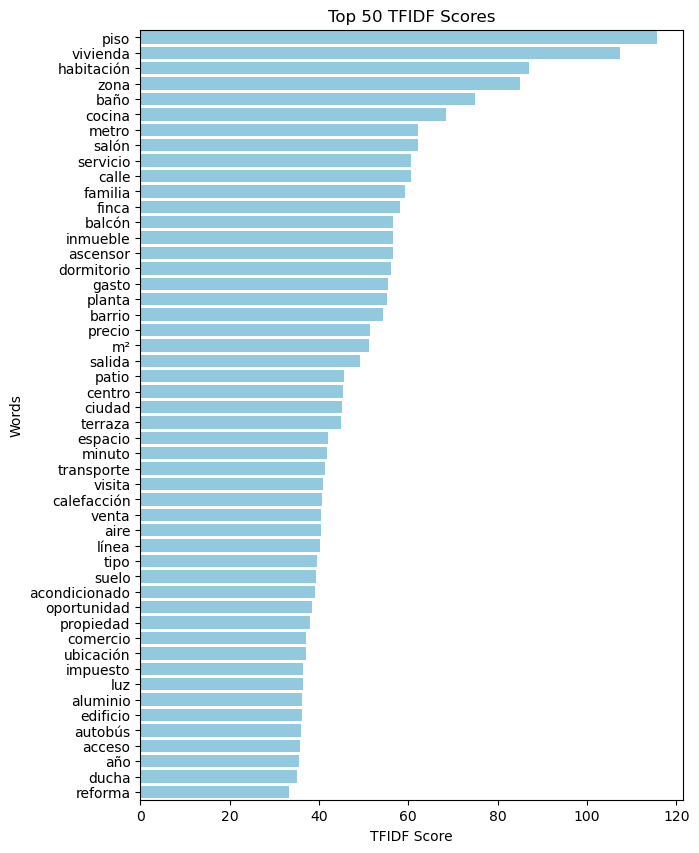

In [133]:
# Visualize top 50 TFIDF Scores
N = 50
top_words_df = pd.DataFrame(top_words_tuples[:N], columns=['Word', 'Frequency'])

plt.figure(figsize=(7, 10))
sns.barplot(x='Frequency', y='Word', data=top_words_df, color='skyblue', orient='h')
plt.xlabel('TFIDF Score')
plt.ylabel('Words')
plt.title(f'Top {N} TFIDF Scores')
plt.show()

In [135]:
X_train['price'] = y_train.values

In [136]:
avg_price_per_word = {}
for word in top_words:
    # Total price associated with each word
    total_price = (X_train[word] * X_train['price']).sum()
    # Count occurrences of the word
    word_count = X_train[word].sum()
    # Calculate the average price
    avg_price_per_word[word] = total_price / word_count if word_count else 0

avg_price_df = pd.DataFrame(list(avg_price_per_word.items()), columns=['Word', 'Average Price'])

avg_price_df.head(10)

,Word,Average Price
0,piso,345488.945233
1,vivienda,345685.581776
2,habitación,345609.946581
3,zona,345496.093458
4,baño,343747.271987
5,cocina,344816.026786
6,metro,345925.965944
7,salón,351740.202765
8,servicio,342720.480287
9,calle,354840.148594


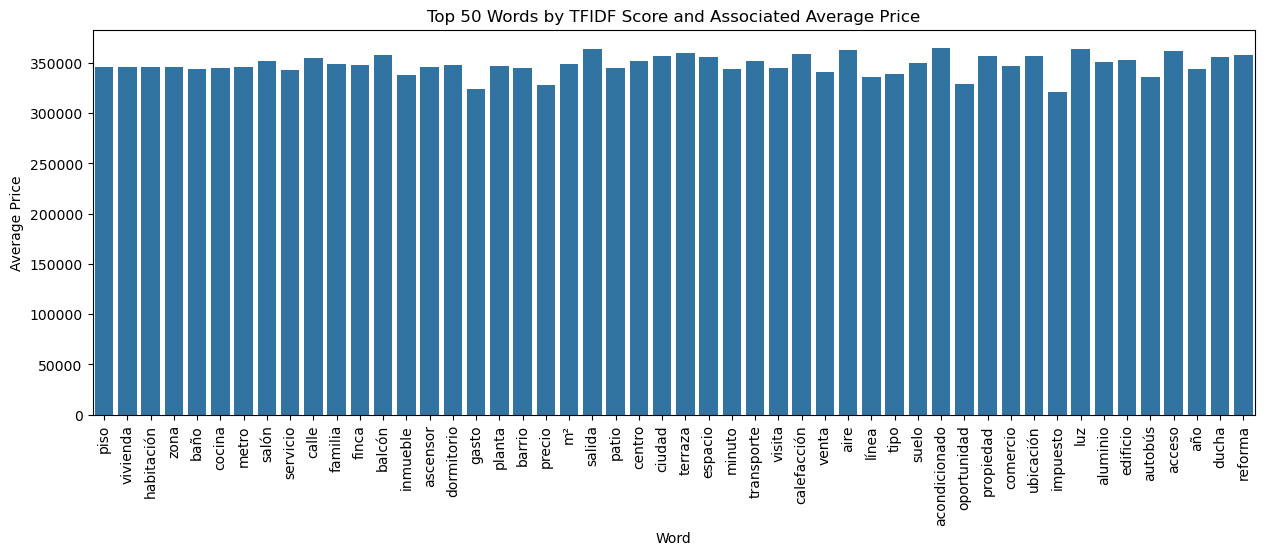

In [144]:
plt.figure(figsize=(15, 5))
sns.barplot(x='Word', y='Average Price', data=avg_price_df, color='tab:blue', orient='v')
plt.xlabel('Word')
plt.ylabel('Average Price')
plt.xticks(rotation=90)
plt.title(f'Top {N} Words by TFIDF Score and Associated Average Price')
plt.show()